In [1]:
#build_models.ipynb
#
#Copyright (c) 2019, Joe Hahn
#
#by Joe Hahn
#joe.hahn@oracle.com
#23 September 2018
#
#build models that predict time til next failure

In [2]:
#start time
import time as tm
clock_start = tm.time()

In [3]:
#import python & helper_fns used below
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)    #tell pandas to display all columns

In [4]:
#import plotting libraries
#use following line when in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

In [5]:
#read pdm input parameters
inputs_path = 'inputs_pdm.py'
execfile(inputs_path)
print 'inputs_path = ', inputs_path
print 'debug = ', debug
print 'N_devices = ', N_devices
print 'sensor_sigma = ', sensor_sigma
print 'N_timesteps = ', N_timesteps
print 'time_start = ', time_start
print 'output_interval = ', output_interval
print 'strategy = ', strategy
print 'pdm_threshold_time = ', pdm_threshold_time
print 'pdm_threshold_probability = ', pdm_threshold_probability
print 'pdm_skip_time = ', pdm_skip_time
print 'N_technicians = ', N_technicians
print 'repair_duration = ', repair_duration
print 'maintenance_duration = ', maintenance_duration
print 'rn_seed = ', rn_seed
print 'issues = ', issues

inputs_path =  inputs_pdm.py
debug =  True
N_devices =  1000
sensor_sigma =  0.01
N_timesteps =  20000
time_start =  0
output_interval =  10
strategy =  pdm
pdm_threshold_time =  400
pdm_threshold_probability =  0.5
pdm_skip_time =  5
N_technicians =  100
repair_duration =  100
maintenance_duration =  25
rn_seed =  18
issues =  {'cracked_valve': {'coefficient': 1e-05, 'fatal': True, 'ID': 2}, 'broken_gear': {'coefficient': 2e-06, 'fatal': True, 'ID': 3}, 'jammed_rotor': {'coefficient': 8e-05, 'fatal': True, 'ID': 1}, 'crud': {'coefficient': 0.1, 'fatal': False, 'ID': 0}}


In [6]:
#get telemetry data, repairs data, and records=telemetry.join.repairs
time_bucket_size = 20
telemetry_file = 'data/telemetry_rtf.csv.gz'
repairs_file = 'data/repairs_rtf.csv.gz'
from helper_fns import * 
telemetry, repairs, records = prep_rtf_data(time_bucket_size, issues, telemetry_file, repairs_file)
print records.dtypes
print 'telemetry.shape = ', telemetry.shape
print 'repairs.shape = ', repairs.shape
print 'records.shape = ', records.shape
records.head()

reading data/telemetry_rtf.csv.gz ...
pivoting telemetry...
reading data/repairs_rtf.csv.gz ...
merging telemetry and repairs...
issue_names =  ['cracked_valve', 'broken_gear', 'jammed_rotor']
computing time to next issue...
computing time since previous issue...
deviceID                      int64
time_bucket                   int64
time                          int64
load                        float64
pressure                    float64
temperature                 float64
production_rate             float64
technicianID                  int64
issue                        object
production_rate_fail        float64
temperature_fail            float64
pressure_fail               float64
load_fail                   float64
time_til_cracked_valve       object
time_til_broken_gear         object
time_til_jammed_rotor        object
time_since_cracked_valve     object
time_since_broken_gear       object
time_since_jammed_rotor      object
dtype: object
telemetry.shape =  (27522320, 5)
repai

,deviceID,time_bucket,time,load,pressure,temperature,production_rate,technicianID,issue,production_rate_fail,temperature_fail,pressure_fail,load_fail,time_til_cracked_valve,time_til_broken_gear,time_til_jammed_rotor,time_since_cracked_valve,time_since_broken_gear,time_since_jammed_rotor
0,0,0,0,0.003613,-0.036010,-0.012448,0.996216,-1,none,NaN,NaN,NaN,NaN,3280,2140,5780,NaN,NaN,NaN
1,0,1,20,-0.040768,-0.027691,-0.019381,0.993463,-1,none,NaN,NaN,NaN,NaN,3260,2120,5760,NaN,NaN,NaN
2,0,2,40,-0.093661,0.007987,-0.001656,0.990108,-1,none,NaN,NaN,NaN,NaN,3240,2100,5740,NaN,NaN,NaN
3,0,3,60,-0.108717,0.006700,0.012203,0.987759,-1,none,NaN,NaN,NaN,NaN,3220,2080,5720,NaN,NaN,NaN
4,0,4,80,-0.097089,-0.059043,0.027068,0.988276,-1,none,NaN,NaN,NaN,NaN,3200,2060,5700,NaN,NaN,NaN


In [7]:
#get fatal issues and their ID
print 'issues = ', issues
fatal_issues = [issue_name for issue_name, d in issues.iteritems() if (d['fatal'] == True)]
fatal_issueIDs = [issues[fatal_issue]['ID'] for fatal_issue in fatal_issues]
print 'fatal_issues = ', fatal_issues
print 'fatal_issueIDs = ', fatal_issueIDs

issues =  {'cracked_valve': {'coefficient': 1e-05, 'fatal': True, 'ID': 2}, 'broken_gear': {'coefficient': 2e-06, 'fatal': True, 'ID': 3}, 'jammed_rotor': {'coefficient': 8e-05, 'fatal': True, 'ID': 1}, 'crud': {'coefficient': 0.1, 'fatal': False, 'ID': 0}}
fatal_issues =  ['cracked_valve', 'broken_gear', 'jammed_rotor']
fatal_issueIDs =  [2, 3, 1]


In [8]:
#list issues & their frequency
df = records
N_issues = df.groupby('issue')['time'].count().sort_values(ascending=False)
print N_issues

issue
none             2460225
jammed_rotor       20682
cracked_valve      11646
broken_gear         7447
Name: time, dtype: int64


In [9]:
#select no-issue records
df = records
idx = (df.issue == 'none') & (df.production_rate > 0.1)
df = df[idx].copy()
records_none = df
print 'records_none.shape = ', records_none.shape
records_none.head()

records_none.shape =  (2292688, 19)


,deviceID,time_bucket,time,load,pressure,temperature,production_rate,technicianID,issue,production_rate_fail,temperature_fail,pressure_fail,load_fail,time_til_cracked_valve,time_til_broken_gear,time_til_jammed_rotor,time_since_cracked_valve,time_since_broken_gear,time_since_jammed_rotor
0,0,0,0,0.003613,-0.036010,-0.012448,0.996216,-1,none,NaN,NaN,NaN,NaN,3280,2140,5780,NaN,NaN,NaN
1,0,1,20,-0.040768,-0.027691,-0.019381,0.993463,-1,none,NaN,NaN,NaN,NaN,3260,2120,5760,NaN,NaN,NaN
2,0,2,40,-0.093661,0.007987,-0.001656,0.990108,-1,none,NaN,NaN,NaN,NaN,3240,2100,5740,NaN,NaN,NaN
3,0,3,60,-0.108717,0.006700,0.012203,0.987759,-1,none,NaN,NaN,NaN,NaN,3220,2080,5720,NaN,NaN,NaN
4,0,4,80,-0.097089,-0.059043,0.027068,0.988276,-1,none,NaN,NaN,NaN,NaN,3200,2060,5700,NaN,NaN,NaN


In [10]:
#flag records whose time_til_issue < pdm_threshold_time
df = records_none
cols = ['deviceID', 'time']
for issue in fatal_issues:
    y_col = issue + '_in_' + str(pdm_threshold_time)
    time_til_col = 'time_til_' + issue
    df[y_col] = 0
    idx = (df[time_til_col] <= pdm_threshold_time)
    df.loc[idx, y_col] = 1
    cols += [time_til_col, y_col]
records_y = df
print 'records_y.shape = ', records_y.shape
records_y[cols][25:35]

records_y.shape =  (2292688, 22)


,deviceID,time,time_til_cracked_valve,cracked_valve_in_400,time_til_broken_gear,broken_gear_in_400,time_til_jammed_rotor,jammed_rotor_in_400
25,0,500,2780,0,1640,0,5280,0
26,0,520,2760,0,1620,0,5260,0
27,0,540,2740,0,1600,0,5240,0
28,0,560,2720,0,1580,0,5220,0
29,0,580,2700,0,1560,0,5200,0
30,0,600,2680,0,1540,0,5180,0
31,0,620,2660,0,1520,0,5160,0
32,0,640,2640,0,1500,0,5140,0
33,0,660,2620,0,1480,0,5120,0
34,0,680,2600,0,1460,0,5100,0


In [11]:
#get x_cols and y_cols
x_cols = ['load', 'pressure', 'temperature', 'production_rate'] + ['time_since_' + issue for issue in fatal_issues]
y_cols = [issue + '_in_' + str(pdm_threshold_time) for issue in fatal_issues]
print 'x_cols = ', x_cols
print 'y_cols = ', y_cols

x_cols =  ['load', 'pressure', 'temperature', 'production_rate', 'time_since_cracked_valve', 'time_since_broken_gear', 'time_since_jammed_rotor']
y_cols =  ['cracked_valve_in_400', 'broken_gear_in_400', 'jammed_rotor_in_400']


In [12]:
#filter records containg nan in any x_col
df = records_y
cols = x_cols + y_cols
idx = df[cols].isna().any(axis=1)
df = df[~idx]
records_filtered = df
print 'records_filtered.shape = ', records_filtered.shape

records_filtered.shape =  (1951803, 22)


In [13]:
#generate xy dataframe containing x features + target variables y
xy = records_filtered
xy.head()

,deviceID,time_bucket,time,load,pressure,temperature,production_rate,technicianID,issue,production_rate_fail,temperature_fail,pressure_fail,load_fail,time_til_cracked_valve,time_til_broken_gear,time_til_jammed_rotor,time_since_cracked_valve,time_since_broken_gear,time_since_jammed_rotor,cracked_valve_in_400,broken_gear_in_400,jammed_rotor_in_400
294,0,294,5880,0.096251,0.091099,-0.010034,0.331636,-1,none,NaN,NaN,NaN,NaN,1980,2440,2680,1220,3740,100,0,0,0
295,0,295,5900,-0.048601,0.059581,-0.032788,0.993107,-1,none,NaN,NaN,NaN,NaN,1960,2420,2660,1240,3760,120,0,0,0
296,0,296,5920,-0.040846,0.098731,-0.011499,0.989815,-1,none,NaN,NaN,NaN,NaN,1940,2400,2640,1260,3780,140,0,0,0
297,0,297,5940,-0.047438,0.150741,-0.015806,0.984134,-1,none,NaN,NaN,NaN,NaN,1920,2380,2620,1280,3800,160,0,0,0
298,0,298,5960,0.030607,0.146879,-0.038791,0.982777,-1,none,NaN,NaN,NaN,NaN,1900,2360,2600,1300,3820,180,0,0,0


In [14]:
#random test-train split
test_size = 0.33
from sklearn.model_selection import train_test_split
xy_train, xy_test = train_test_split(xy, test_size=test_size)
xy_test = xy_test.copy()
print 'xy_train.shape = ', xy_train.shape
print 'xy_test.shape = ', xy_test.shape

xy_train.shape =  (1307708, 22)
xy_test.shape =  (644095, 22)


In [15]:
#build a random forest classifier
n_estimators = 51
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=n_estimators, random_state=rn_seed)
model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 51,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 18,
 'verbose': 0,
 'warm_start': False}

In [16]:
#train & save models...takes 20 minutes
make_models = True
df = xy_train
import pickle as pkl
#model_folder = '/u01/bdcsce/tmp/'
model_folder = './'
if (make_models):
    for y_col in y_cols:
        x_train = df[x_cols].values
        y_train = df[y_col].values
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=rn_seed)
        model.fit(x_train, y_train)
        #save model
        model_file = model_folder + y_col + '_model.pkl'
        with open(model_file, 'wb') as file:  
            pkl.dump(model, file)
        print '   saving ' + model_file

   saving ./cracked_valve_in_400_model.pkl
   saving ./broken_gear_in_400_model.pkl
   saving ./jammed_rotor_in_400_model.pkl


In [17]:
#restore models
models = {}
for y_col in y_cols:
    model_file = model_folder + y_col + '_model.pkl'
    with open(model_file, 'rb') as file:  
        models[y_col] = pkl.load(file)
models

{'broken_gear_in_400': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=None,
             oob_score=False, random_state=18, verbose=0, warm_start=False),
 'cracked_valve_in_400': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=None,
             oob_score=False, random_state=18, verbose=0, warm_start=False),
 'jammed_rotor_in_400': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_dep

In [18]:
#compute predictions & probabilities for test sample
x_test = xy_test[x_cols]
cols = ['deviceID', 'time', 'issue']
for y_col in y_cols:
    model = models[y_col]
    y_col_pred = y_col + '_pred'
    xy_test[y_col_pred] = model.predict(x_test)
    class_prob = model.predict_proba(x_test)
    classes = model.classes_
    cols += [y_col, y_col_pred]
    for cls in classes:
        y_col_prob = y_col_pred + '_prob' + str(cls)
        xy_test[y_col_prob] = class_prob[:, cls]
        cols += [y_col_prob]
xy_test[cols].tail()

,deviceID,time,issue,cracked_valve_in_400,cracked_valve_in_400_pred,cracked_valve_in_400_pred_prob0,cracked_valve_in_400_pred_prob1,broken_gear_in_400,broken_gear_in_400_pred,broken_gear_in_400_pred_prob0,broken_gear_in_400_pred_prob1,jammed_rotor_in_400,jammed_rotor_in_400_pred,jammed_rotor_in_400_pred_prob0,jammed_rotor_in_400_pred_prob1
888,476,17760,none,0,0,0.960784,0.039216,0,0,0.980392,0.019608,0,0,0.686275,0.313725
1047,270,20940,none,0,0,0.745098,0.254902,0,0,0.960784,0.039216,0,0,0.980392,0.019608
1010,384,20200,none,0,0,1.000000,0.000000,1,0,0.803922,0.196078,0,0,0.627451,0.372549
1442,488,28840,none,0,0,1.000000,0.000000,0,0,0.960784,0.039216,0,0,0.568627,0.431373
1525,916,30500,none,0,0,1.000000,0.000000,0,0,0.980392,0.019608,1,0,0.568627,0.431373


In [19]:
#save xy_test as csv
xy_test.to_csv('data/xy_test.csv.gz', header=False, index=False, sep='|', compression='gzip')
xy_test.dtypes

deviceID                             int64
time_bucket                          int64
time                                 int64
load                               float64
pressure                           float64
temperature                        float64
production_rate                    float64
technicianID                         int64
issue                               object
production_rate_fail               float64
temperature_fail                   float64
pressure_fail                      float64
load_fail                          float64
time_til_cracked_valve              object
time_til_broken_gear                object
time_til_jammed_rotor               object
time_since_cracked_valve            object
time_since_broken_gear              object
time_since_jammed_rotor             object
cracked_valve_in_400                 int64
broken_gear_in_400                   int64
jammed_rotor_in_400                  int64
cracked_valve_in_400_pred            int64
cracked_val

In [20]:
#compute issue-wise true & false positive fraction vs prediction probability
df = xy_test
false_positive_fraction = pd.DataFrame()
true_positive_fraction = pd.DataFrame()
for y_col in y_cols:
    y_col_pred = y_col + '_pred'
    df1 = df[df[y_col_pred] == 1].copy()
    y_col_prob1 = y_col_pred + '_prob1'
    probability = np.sort(df1[y_col_prob1].unique())
    false_pos_frac = np.zeros_like(probability)
    true_pos_frac = np.zeros_like(probability)
    for idx in range(len(probability)):
        prob = probability[idx]
        prob_min = prob - 0.001
        jdx = (df1[y_col_prob1] > prob_min)
        dfp = df1[jdx]
        false_positive = dfp[dfp[y_col] == 0]
        N_false_positive = len(false_positive)
        #if (N_false_positive < 1):
        #    N_false_positive += 1*0
        true_positive = dfp[dfp[y_col] == 1]
        N_true_positive = len(true_positive)
        N_positive = N_true_positive + N_false_positive
        false_pos_frac[idx] = N_false_positive*1.0/N_positive
        true_pos_frac[idx] = N_true_positive*1.0/N_positive
    false_positive_fraction[y_col] = pd.Series(data=false_pos_frac, index=probability)
    true_positive_fraction[y_col] = pd.Series(data=true_pos_frac, index=probability)
false_positive_fraction.index.name = 'probability'
true_positive_fraction.index.name = 'probability'

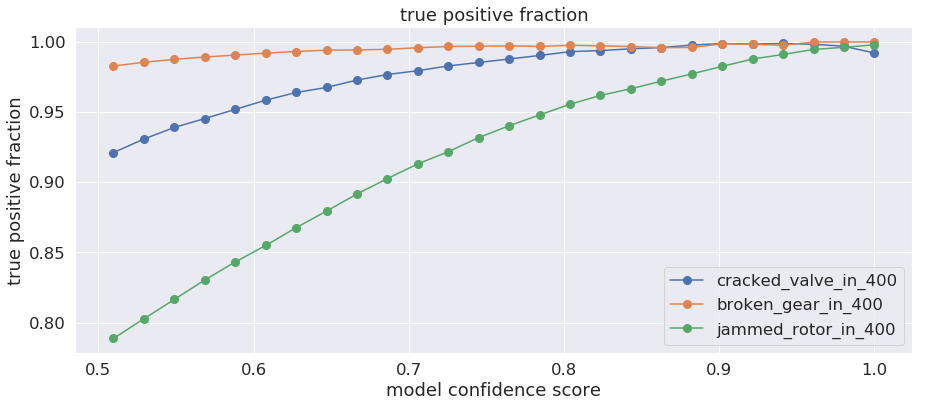

In [21]:
#plot true positive fraction vs prediction probability
df = true_positive_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('true positive fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('true positive fraction')
#p = ax.set_yscale('log')
#p = ax.set_ylim(0.0009, 1.1)
p = ax.legend()

In [22]:
df.tail()

,cracked_valve_in_400,broken_gear_in_400,jammed_rotor_in_400
probability,,,
0.921569,0.998526,0.998325,0.987874
0.941176,0.998936,0.997602,0.991096
0.960784,0.998350,1.000000,0.994675
0.980392,0.996970,1.000000,0.996189
1.000000,0.992126,1.000000,0.997973


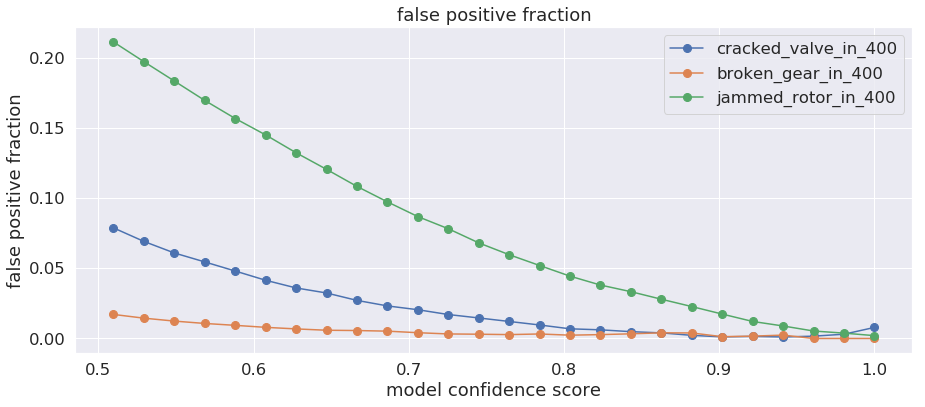

In [23]:
#plot false positive fraction vs prediction probability, for each issue
df = false_positive_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('false positive fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('false positive fraction')
p = ax.legend()

In [24]:
df.tail()

,cracked_valve_in_400,broken_gear_in_400,jammed_rotor_in_400
probability,,,
0.921569,0.001474,0.001675,0.012126
0.941176,0.001064,0.002398,0.008904
0.960784,0.001650,0.000000,0.005325
0.980392,0.003030,0.000000,0.003811
1.000000,0.007874,0.000000,0.002027


In [25]:
#compute overall true & false positive fraction vs prediction probability
df = xy_test
small = 0.001
true_positive_fraction = np.zeros_like(probability)
false_positive_fraction = np.zeros_like(probability)
for idx in range(len(probability)):
    prob = probability[idx]
    jdx = ((df.cracked_valve_in_400_pred == 1) & (df.cracked_valve_in_400_pred_prob1 > prob - small)) | \
          ((df.broken_gear_in_400_pred   == 1) & (df.broken_gear_in_400_pred_prob1   > prob - small)) | \
          ((df.jammed_rotor_in_400_pred  == 1) & (df.jammed_rotor_in_400_pred_prob1  > prob - small))
    df1 = df[jdx]
    N_true = len(df1)
    jdx = (df1.cracked_valve_in_400 == 1) | (df1.broken_gear_in_400 == 1) | (df1.jammed_rotor_in_400 == 1)
    N_true_positive = len(df1[jdx])
    jdx = (df1.cracked_valve_in_400 == 0) & (df1.broken_gear_in_400 == 0) & (df1.jammed_rotor_in_400 == 0)
    N_false_positive = len(df1[jdx])
    true_positive_fraction[idx] = N_true_positive*1.0/N_true
    false_positive_fraction[idx] = N_false_positive*1.0/N_true
data={'true_positive_fraction':true_positive_fraction, 'false_positive_fraction':false_positive_fraction}
TF_fraction = pd.DataFrame(data=data, index=probability)
TF_fraction.index.name = 'probability'
TF_fraction.tail()

,false_positive_fraction,true_positive_fraction
probability,,
0.921569,0.008090,0.991910
0.941176,0.006524,0.993476
0.960784,0.003650,0.996350
0.980392,0.003046,0.996954
1.000000,0.002418,0.997582


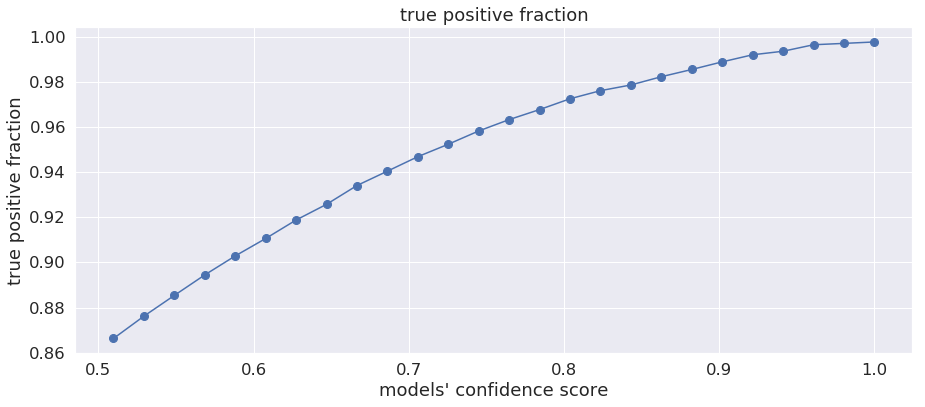

In [26]:
#plot overall true & false positive fraction vs prediction probability
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['true_positive_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('true positive fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('true positive fraction')

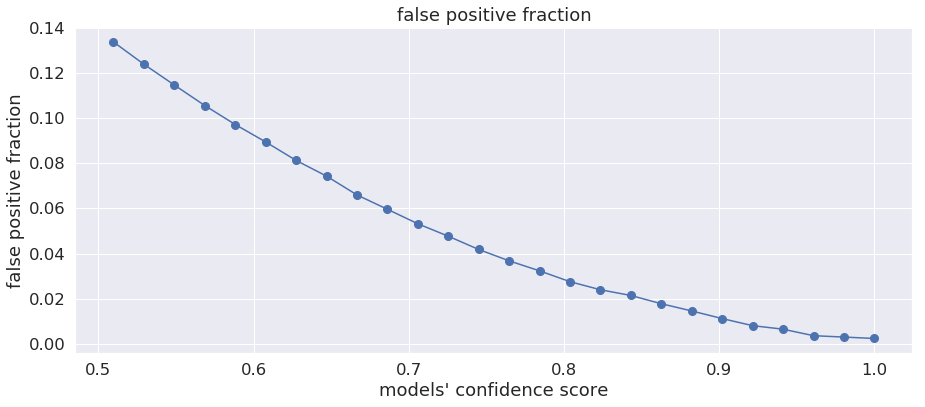

In [27]:
#plot overall false positive fraction vs prediction probability
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['false_positive_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('false positive fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('false positive fraction')
plt.savefig('figs/false_positives.png')

In [28]:
#compute issue-wise true & false negative fraction vs prediction probability
df = xy_test
false_negative_fraction = pd.DataFrame()
true_negative_fraction = pd.DataFrame()
for y_col in y_cols:
    y_col_pred = y_col + '_pred'
    df0 = df[df[y_col_pred] == 0].copy()
    y_col_prob0 = y_col_pred + '_prob0'
    probability = np.sort(df0[y_col_prob0].unique())
    false_neg_frac = np.zeros_like(probability)
    true_neg_frac = np.zeros_like(probability)
    for idx in range(len(probability)):
        prob = probability[idx]
        prob_min = prob - 0.001
        jdx = (df0[y_col_prob0] > prob_min)
        dfn = df0[jdx]
        false_negative = dfn[dfn[y_col] == 1]
        N_false_negative = len(false_negative)
        true_negative = dfn[dfn[y_col] == 0]
        N_true_negative = len(true_negative)
        N_negative = N_true_negative + N_false_negative
        false_neg_frac[idx] = N_false_negative*1.0/N_negative
        true_neg_frac[idx] = N_true_negative*1.0/N_negative
    false_negative_fraction[y_col] = pd.Series(data=false_neg_frac, index=probability)
    true_negative_fraction[y_col] = pd.Series(data=true_neg_frac, index=probability)
false_negative_fraction.index.name = 'probability'
true_negative_fraction.index.name = 'probability'

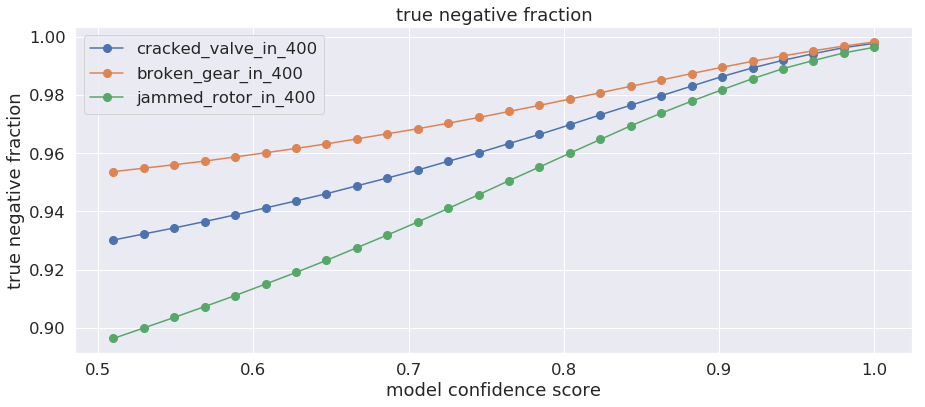

In [29]:
#plot true negative fraction vs prediction probability
df = true_negative_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('true negative fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('true negative fraction')
p = ax.legend()

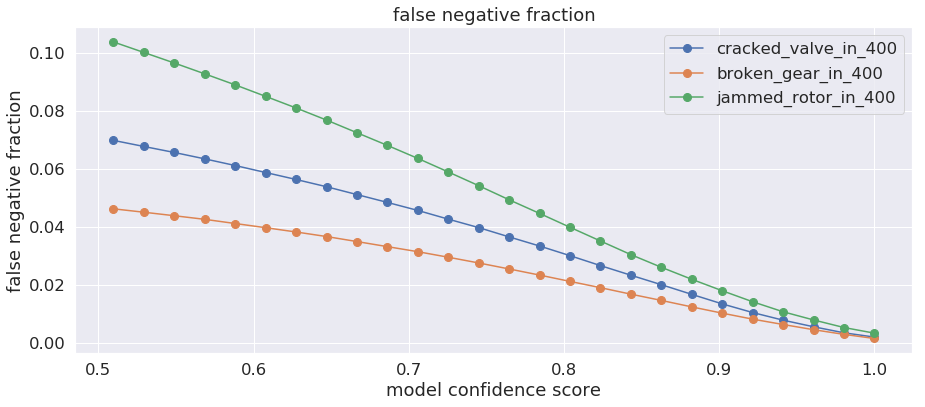

In [30]:
#plot false negative fraction vs prediction probability
df = false_negative_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for y_col in y_cols:
    xp = df.index
    yp = df[y_col]
    p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8, label=y_col)
p = ax.set_title('false negative fraction')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('false negative fraction')
p = ax.legend()

In [31]:
#compute overall true & false negative fraction vs prediction probability
df = xy_test
small = 0.001
true_negative_fraction = np.zeros_like(probability)
false_negative_fraction = np.zeros_like(probability)
for idx in range(len(probability)):
    prob = probability[idx]
    jdx = ((df.cracked_valve_in_400_pred == 0) & (df.cracked_valve_in_400_pred_prob0 > prob - small)) & \
          ((df.broken_gear_in_400_pred   == 0) & (df.broken_gear_in_400_pred_prob0   > prob - small)) & \
          ((df.jammed_rotor_in_400_pred  == 0) & (df.jammed_rotor_in_400_pred_prob0  > prob - small))
    df0 = df[jdx]
    N_negative = len(df0)
    jdx = (df0.cracked_valve_in_400 == 0) & (df0.broken_gear_in_400 == 0) & (df0.jammed_rotor_in_400 == 0)
    N_true_negative = len(df0[jdx])
    jdx = (df0.cracked_valve_in_400 == 1) | (df0.broken_gear_in_400 == 1) | (df0.jammed_rotor_in_400 == 1)
    N_false_negative = len(df0[jdx])
    true_negative_fraction[idx] = N_true_negative*1.0/N_negative
    false_negative_fraction[idx] = N_false_negative*1.0/N_negative
data={'true_negative_fraction':true_negative_fraction, 'false_negative_fraction':false_negative_fraction}
TF_fraction = pd.DataFrame(data=data, index=probability)
TF_fraction.index.name = 'probability'
TF_fraction.tail()

,false_negative_fraction,true_negative_fraction
probability,,
0.921569,0.033331,0.966669
0.941176,0.023597,0.976403
0.960784,0.014140,0.985860
0.980392,0.007051,0.992949
1.000000,0.002185,0.997815


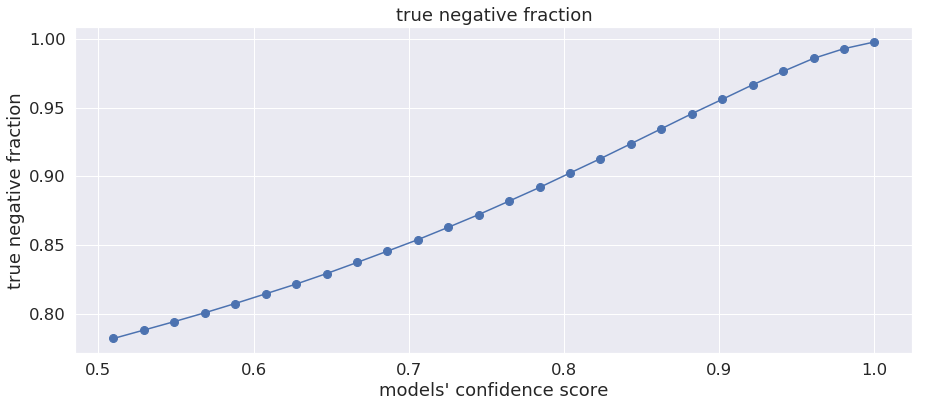

In [32]:
#plot overall true negative fraction vs prediction probability
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['true_negative_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('true negative fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('true negative fraction')

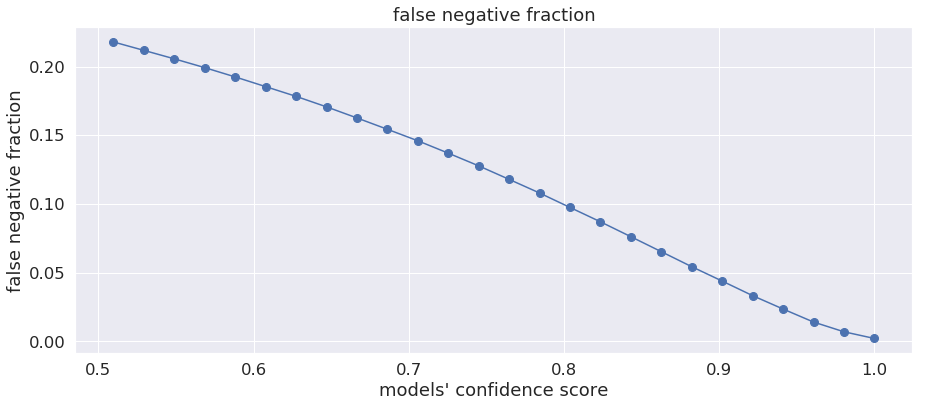

In [33]:
#plot overall false negative fraction vs prediction probability...this plot looks funny, is it correct?
df = TF_fraction
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = df.index
yp = df['false_negative_fraction']
p = ax.plot(xp, yp, linestyle='-', marker='o', markersize=8)
p = ax.set_title('false negative fraction')
p = ax.set_xlabel("models' confidence score")
p = ax.set_ylabel('false negative fraction')
plt.savefig('figs/false_negatives.png')

In [34]:
#done
print 'execution time (min) = ', (tm.time() - clock_start)/60.0

execution time (min) =  21.9521139661
